Instalando unidecode para remover acentos...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.6 MB/s eta 0:00:00
Unidecode instalado.
Por favor, faça o upload do arquivo survey limpo (ex: 'survey_cleaned-1.csv'):


Saving survey_cleaned.csv to survey_cleaned.csv

Arquivo 'survey_cleaned.csv' carregado.

(Opcional) Por favor, faça o upload do arquivo de microdados (ex: 'microdados_agrupados_por_uf-1.csv'):


Saving microdados_agrupados_por_uf (1).csv to microdados_agrupados_por_uf (1).csv

Arquivo 'microdados_agrupados_por_uf (1).csv' carregado.
Cabeçalho detectado como tupla.

Dataset Survey carregado. Shape: (4746, 36)

Dataset Microdados carregado. Shape: (27, 12)

Nomes das colunas do Survey (APÓS LIMPEZA REFINADA):

Verificando colunas selecionadas...
Coluna target encontrada: 'faixa_salarial'

Aviso: As seguintes features esperadas não foram encontradas após limpeza refinada: ['ccc', 'corracaoetnia', 'entre_as_linguagens_listadas_abaixo_qual_a_que_voce_mais_utiliza_no_trabalho']
  => Verifique a lista 'feature_columns_expected_clean' ou a função de limpeza.

Features válidas finais (32) a serem usadas: ['nivel_de_ensino', 'area_de_formacao', 'quanto_tempo_de_experiencia_na_area_de_dados_voce_tem', 'nivel', 'sql', 'r', 'python', 'net', 'java', 'julia', 'sasstata', 'visual_basicvba', 'scala', 'matlab', 'rust', 'php', 'javascript', 'nao_utilizo_nenhuma_linguagem', 'genero', 'setor', 'uf

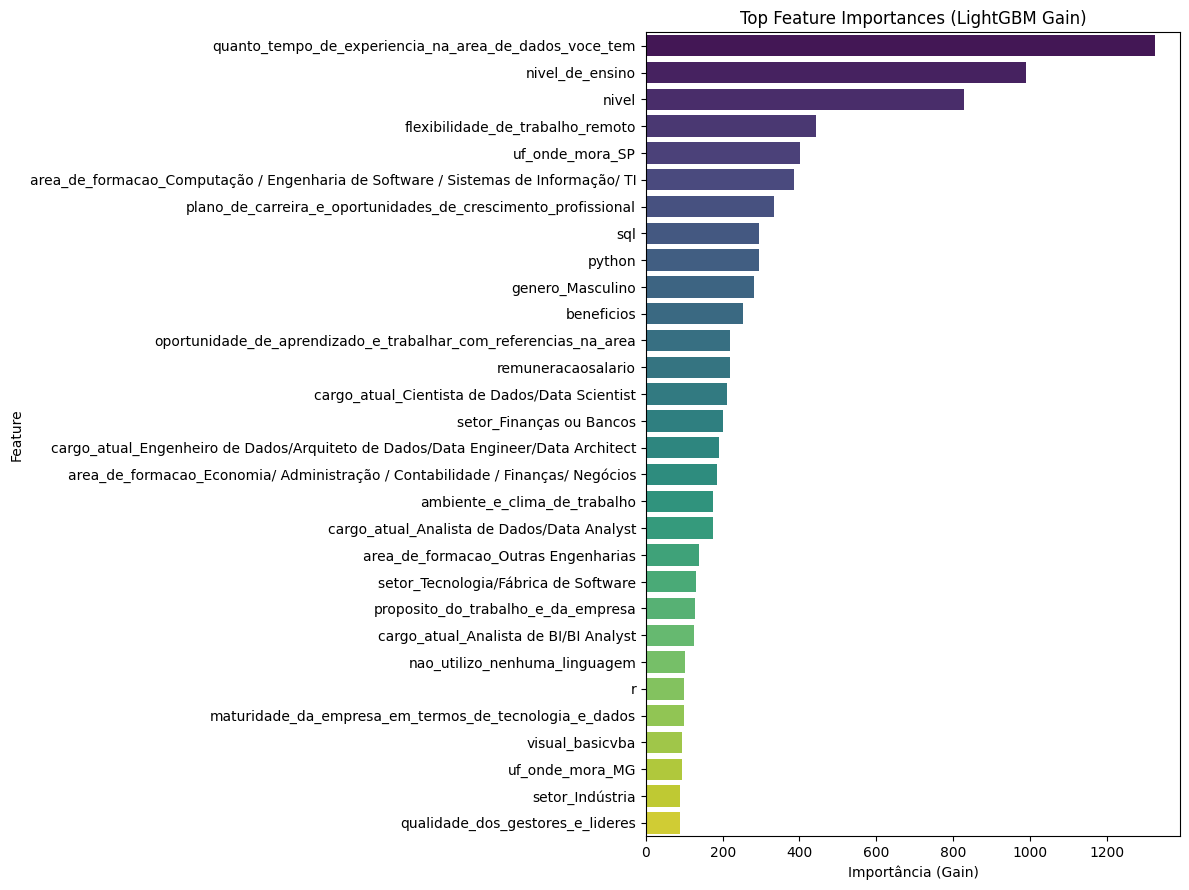


7.2 Visualização de Árvore Individual (Exemplo: Árvore 0):
Árvore 0 salva como lgbm_tree_0_corrected_final.png


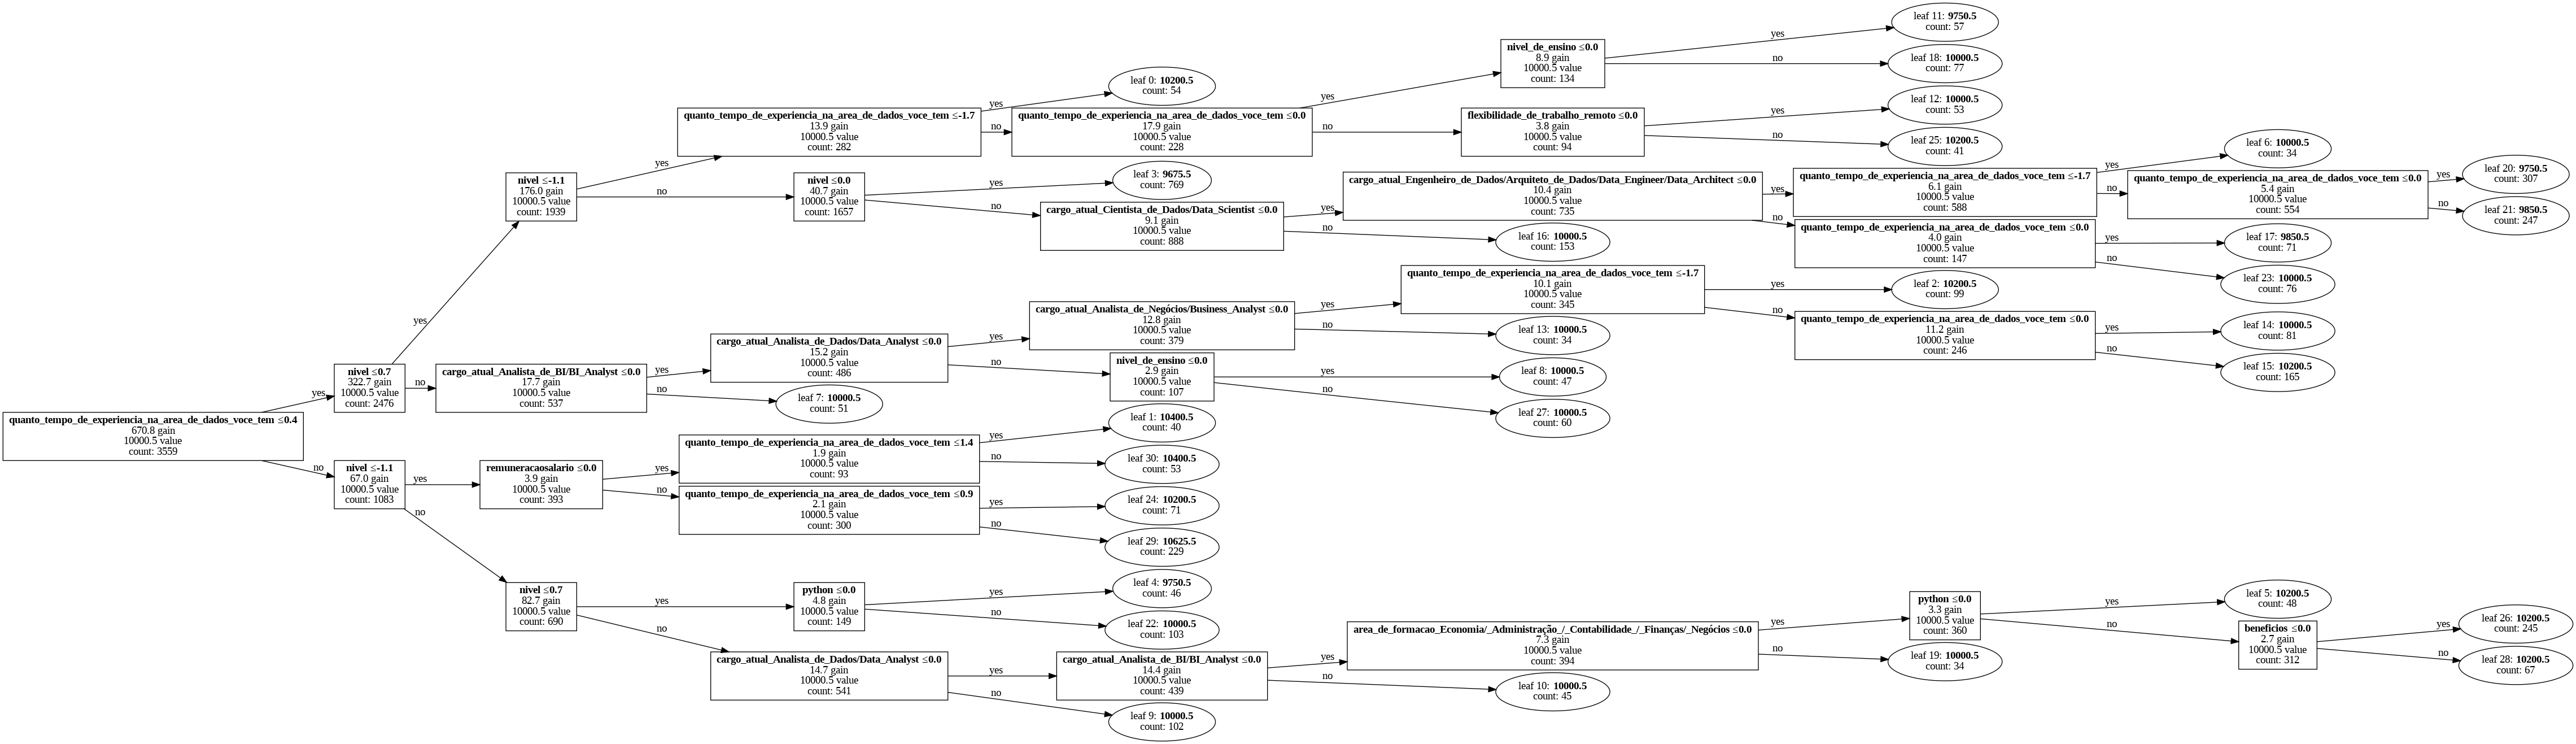


--- 7.3 Interpretação SHAP ---
Calculando SHAP values...
Cálculo SHAP concluído.

Plotando Resumo SHAP (dot)...


<ipython-input-1-db0d2f3ce3ee>:544: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


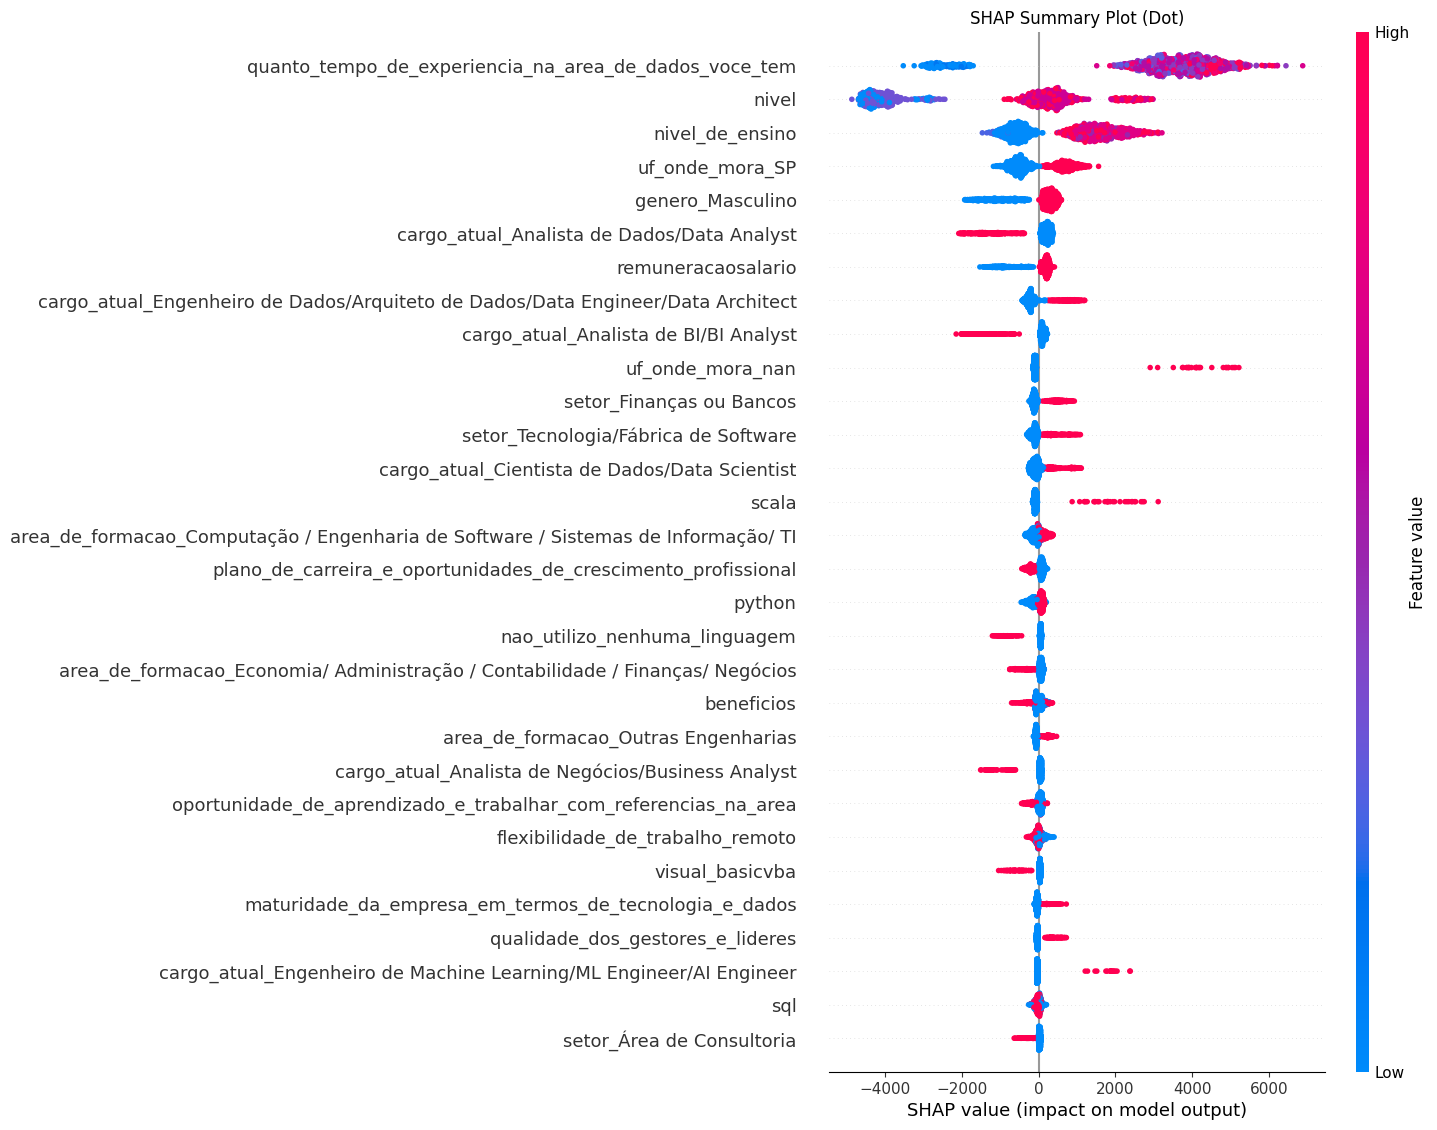


Plotando Resumo SHAP (bar)...


<ipython-input-1-db0d2f3ce3ee>:552: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


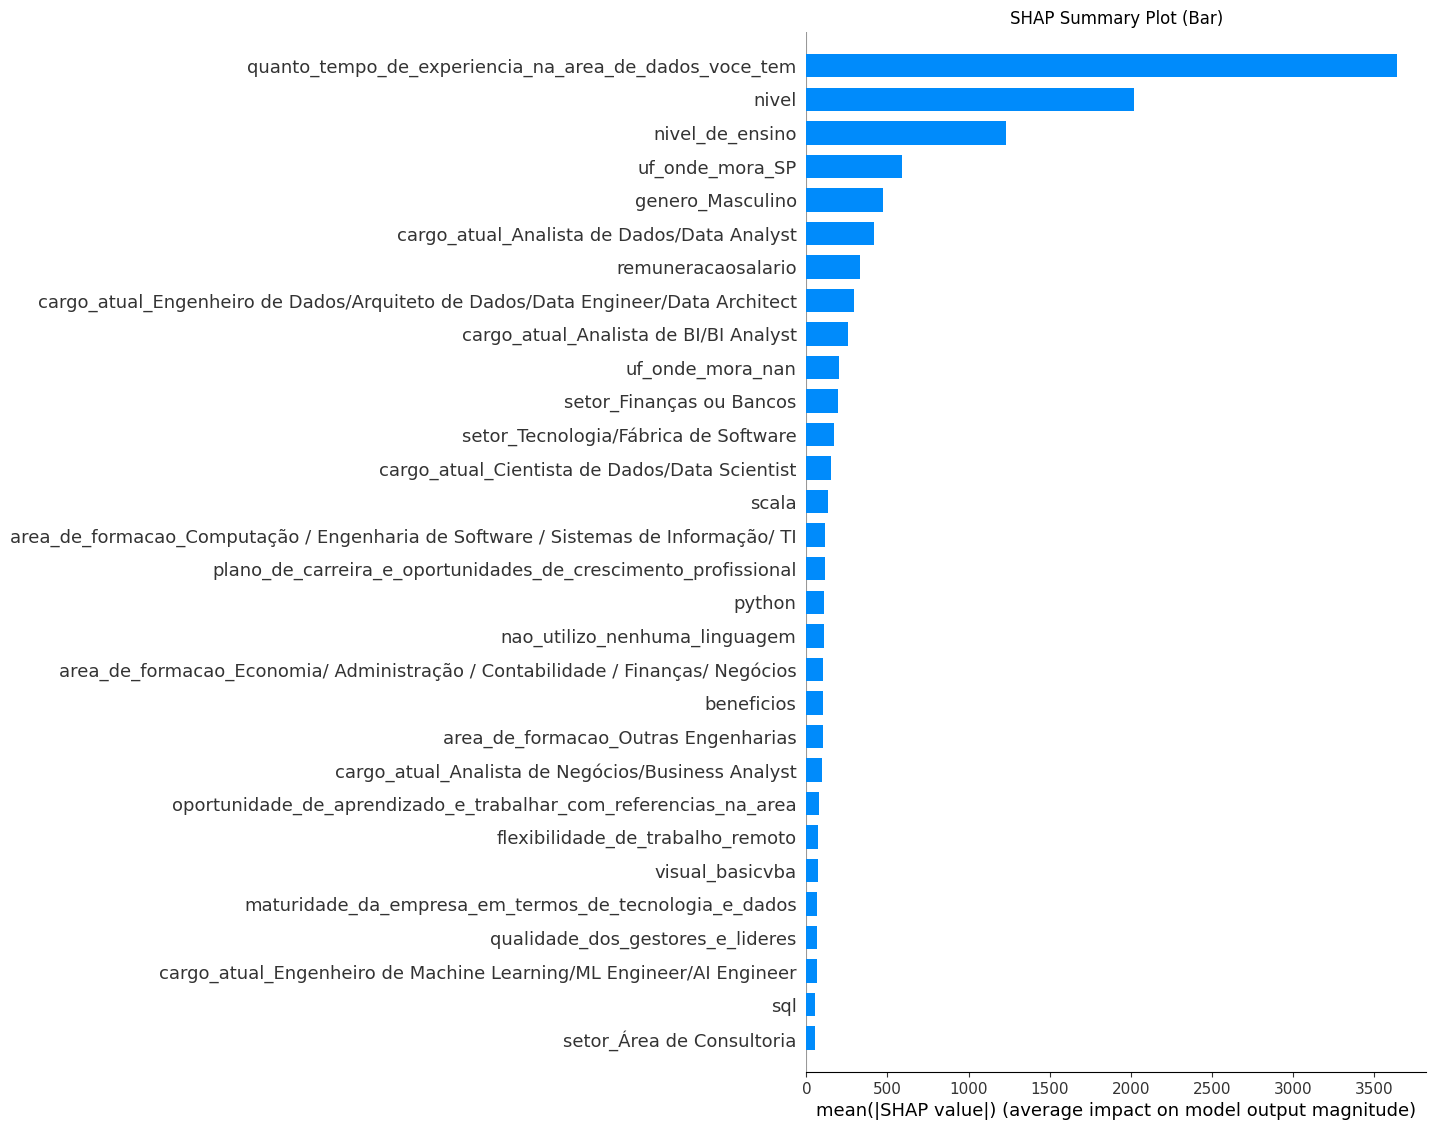


Plotando SHAP Dependence Plots (exemplos)...

Plotando Dependência SHAP: 'quanto_tempo_de_experiencia_na_area_de_dados_voce_tem' vs Salário (colorido por 'nivel_de_ensino')


<Figure size 640x480 with 0 Axes>

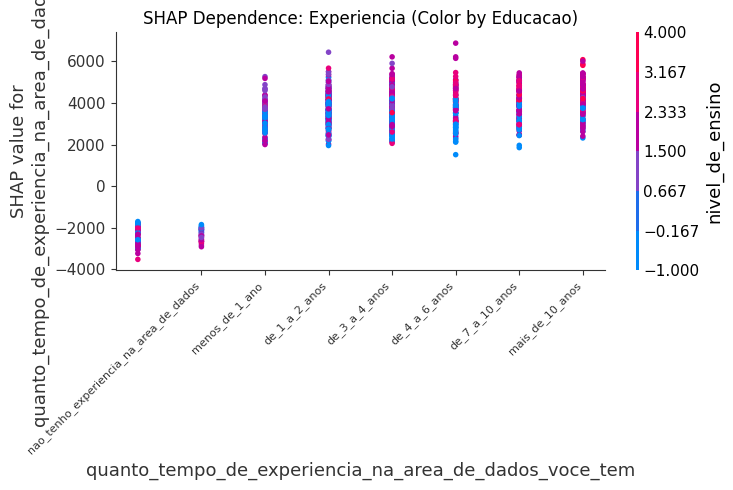


Plotando Dependência SHAP: 'nivel' vs Salário (colorido por 'quanto_tempo_de_experiencia_na_area_de_dados_voce_tem')


<Figure size 640x480 with 0 Axes>

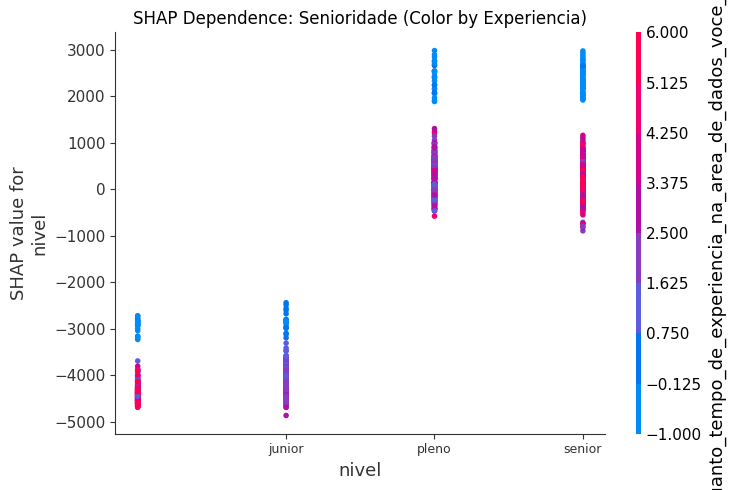


Plotando Dependência SHAP: 'python' (Uso Python) vs Salário (colorido por 'quanto_tempo_de_experiencia_na_area_de_dados_voce_tem')


<Figure size 640x480 with 0 Axes>

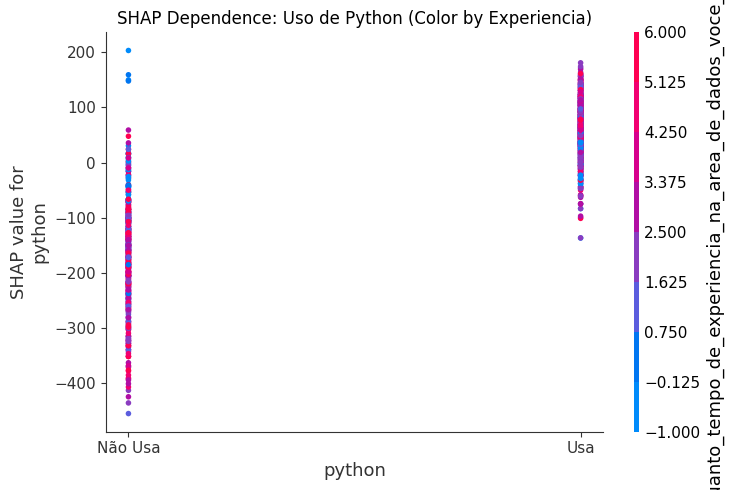


--- Fim da Análise ---


In [ ]:
# -*- coding: utf-8 -*-
"""
CÓDIGO COMPLETO E CORRIGIDO para Google Colab:
Modelo GBM para previsão salarial com pré-processamento robusto,
codificação ordinal/nominal correta, otimização e interpretação SHAP completa.
"""

# --- Etapa 1: Configuração do Ambiente, Upload e Carregamento ---

# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import re
import io
from google.colab import files
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Instalar/Importar bibliotecas opcionais
try:
    from unidecode import unidecode
except ImportError:
    print("Instalando unidecode para remover acentos...")
    !pip install unidecode
    from unidecode import unidecode
    print("Unidecode instalado.")

try:
    import shap
except ImportError:
    print("Instalando shap para interpretação do modelo...")
    !pip install shap
    import shap
    print("Shap instalado.")

try:
    import graphviz
except ImportError:
    print("Instalando graphviz para visualização de árvore...")
    !apt-get install -qq graphviz > /dev/null # Instala dependência do sistema no Colab
    !pip install graphviz > /dev/null
    import graphviz
    print("Graphviz instalado.")

# Ignorar warnings específicos que podem poluir a saída
warnings.filterwarnings("ignore", category=UserWarning, module='shap')
warnings.filterwarnings("ignore", category=FutureWarning)


# --- Upload dos Arquivos ---
print("Por favor, faça o upload do arquivo survey limpo (ex: 'survey_cleaned-1.csv'):")
uploaded_survey = files.upload()
if not uploaded_survey:
    raise FileNotFoundError("Nenhum arquivo de pesquisa (survey) foi carregado.")
survey_filename = list(uploaded_survey.keys())[0]
print(f"\nArquivo '{survey_filename}' carregado.")

print("\n(Opcional) Por favor, faça o upload do arquivo de microdados (ex: 'microdados_agrupados_por_uf-1.csv'):")
uploaded_microdados = files.upload()
if uploaded_microdados:
    microdados_filename = list(uploaded_microdados.keys())[0]
    print(f"\nArquivo '{microdados_filename}' carregado.")
else:
    print("\nNenhum arquivo microdados carregado. Prosseguindo sem ele.")
    microdados_filename = None
    df_microdados = None

# --- Carregamento dos Dados ---
try:
    # Tenta detectar o separador (',' ou ';') - Ajustado para ler cabeçalho corretamente
    try:
        # Tenta ler com cabeçalho como tupla, depois como string normal
        try:
             # Lê a primeira linha para verificar se é tupla
             first_line = pd.read_csv(io.BytesIO(uploaded_survey[survey_filename]), sep=',', encoding='utf-8', engine='python', nrows=1).columns[0]
             if first_line.startswith("('"): # Detecta formato de tupla no cabeçalho
                 df = pd.read_csv(io.BytesIO(uploaded_survey[survey_filename]), sep=',', encoding='utf-8', engine='python', header=0) # Header=0 é o default, mas explícito
                 print("Cabeçalho detectado como tupla.")
             else: # Assume cabeçalho normal
                 df = pd.read_csv(io.BytesIO(uploaded_survey[survey_filename]), sep=',', encoding='utf-8', engine='python')
                 print("Cabeçalho detectado como string normal.")
        except: # Tenta com ';' se ',' falhar ou gerar erro
             first_line = pd.read_csv(io.BytesIO(uploaded_survey[survey_filename]), sep=';', encoding='utf-8', engine='python', nrows=1).columns[0]
             if first_line.startswith("('"):
                 df = pd.read_csv(io.BytesIO(uploaded_survey[survey_filename]), sep=';', encoding='utf-8', engine='python', header=0)
                 print("Cabeçalho detectado como tupla (sep=';').")
             else:
                 df = pd.read_csv(io.BytesIO(uploaded_survey[survey_filename]), sep=';', encoding='utf-8', engine='python')
                 print("Cabeçalho detectado como string normal (sep=';').")

    except Exception as e:
        print(f"Erro complexo na leitura CSV. Tentando leitura simples com sep=',' : {e}")
        df = pd.read_csv(io.BytesIO(uploaded_survey[survey_filename]), sep=',', encoding='utf-8', engine='python')
        if df.shape[1] <= 1:
            print("Leitura com ',' falhou, tentando com ';'")
            df = pd.read_csv(io.BytesIO(uploaded_survey[survey_filename]), sep=';', encoding='utf-8', engine='python')

    print(f"\nDataset Survey carregado. Shape: {df.shape}")
    # print("Primeiras linhas do Survey:")
    # print(df.head())
    # print("\nTipos de dados iniciais:")
    # print(df.info())
    # print("\nNomes das colunas ANTES da limpeza:")
    # print(df.columns.tolist())


except Exception as e:
    print(f"Erro CRÍTICO ao carregar Survey: {e}")
    raise

if microdados_filename and uploaded_microdados:
    try:
        # Tenta detectar o separador para microdados
        try:
            df_microdados = pd.read_csv(io.BytesIO(uploaded_microdados[microdados_filename]), sep=',', encoding='utf-8', engine='python')
            if df_microdados.shape[1] <=1:
                 df_microdados = pd.read_csv(io.BytesIO(uploaded_microdados[microdados_filename]), sep=';', encoding='utf-8', engine='python')
        except pd.errors.ParserError:
             df_microdados = pd.read_csv(io.BytesIO(uploaded_microdados[microdados_filename]), sep=';', encoding='utf-8', engine='python')
        print(f"\nDataset Microdados carregado. Shape: {df_microdados.shape}")
    except Exception as e:
        print(f"Erro ao carregar Microdados: {e}")
        df_microdados = None


# --- Função de Limpeza REFINADA ---
def clean_col_names_refined(df_to_clean):
    if df_to_clean is None: return None
    new_cols = {}
    col_counts = {}
    for i, col in enumerate(df_to_clean.columns):
        try:
            # Remove aspas e parênteses iniciais/finais, comum em cabeçalhos tupla-like
            col_str = str(col).strip("()'")
            # Se era uma tupla 'a','b', pega só a descrição 'b' se possível
            parts = col_str.split("', '")
            if len(parts) == 2:
                col_str = parts[1] # Pega a segunda parte (descrição)
            elif len(parts) == 1:
                 # Se tinha só ('P4_d_1 ',) por exemplo, remove aspas residuais
                 col_str = parts[0].strip("' ")
        except:
            col_str = str(col) # Fallback para string original

        # Limpeza Refinada:
        clean_name = col_str.lower() # Lowercase primeiro
        clean_name = unidecode(clean_name) # Remove acentos
        clean_name = re.sub(r'[?()/,.:#\-\[\]\'"]+', '', clean_name) # Remove pontuação básica
        clean_name = clean_name.replace(' ', '_') # Espaços -> underscore
        clean_name = re.sub(r'[^a-z0-9_]+', '_', clean_name) # Remove outros caracteres especiais
        clean_name = re.sub(r'_+', '_', clean_name) # Consolida underscores
        clean_name = clean_name.strip('_') # Remove do início/fim

        if not clean_name: clean_name = f"col_{hash(col)}" # Garante nome não vazio

        original_clean_name = clean_name
        count = col_counts.get(clean_name, 0)
        if count > 0: clean_name = f"{original_clean_name}_{count}"
        col_counts[original_clean_name] = count + 1
        new_cols[col] = clean_name
    df_cleaned = df_to_clean.rename(columns=new_cols)
    return df_cleaned

# Aplicar limpeza
df = clean_col_names_refined(df)
print("\nNomes das colunas do Survey (APÓS LIMPEZA REFINADA):")
# print(df.columns.tolist()) # Mostra a lista completa para debug se necessário

if df_microdados is not None:
    df_microdados = clean_col_names_refined(df_microdados)


# --- Etapa 2: Definição da Variável Alvo e Seleção de Features ---

# Nomes das colunas APÓS a limpeza refinada (verificar se correspondem à sua necessidade)
target_column_clean_final = 'faixa_salarial' # Nome esperado após limpeza refinada da tupla ('P2_h ', 'Faixa salarial')

# Lista das features ESPERADAS após limpeza refinada
# Verifique esta lista com atenção contra a saída real da limpeza, se necessário
feature_columns_expected_clean = [
    'nivel_de_ensino', 'area_de_formacao',
    'quanto_tempo_de_experiencia_na_area_de_dados_voce_tem', 'nivel',
    'sql', 'r', 'python', 'ccc', 'net', 'java',
    'julia', 'sasstata', 'visual_basicvba', 'scala',
    'matlab', 'rust', 'php', 'javascript',
    'nao_utilizo_nenhuma_linguagem',
    'genero', 'corracaoetnia', 'setor',
    'uf_onde_mora', 'cargo_atual',
    'entre_as_linguagens_listadas_abaixo_qual_a_que_voce_mais_utiliza_no_trabalho',
    'remuneracaosalario', 'beneficios',
    'proposito_do_trabalho_e_da_empresa', 'flexibilidade_de_trabalho_remoto',
    'ambiente_e_clima_de_trabalho',
    'oportunidade_de_aprendizado_e_trabalhar_com_referencias_na_area',
    'plano_de_carreira_e_oportunidades_de_crescimento_profissional',
    'maturidade_da_empresa_em_termos_de_tecnologia_e_dados',
    'qualidade_dos_gestores_e_lideres', 'reputacao_que_a_empresa_tem_no_mercado'
]

# Verificação e Seleção
print("\nVerificando colunas selecionadas...")
if target_column_clean_final not in df.columns:
    print(f"Erro CRÍTICO: Coluna target '{target_column_clean_final}' não encontrada. Colunas disponíveis:")
    print(df.columns.tolist())
    raise KeyError(f"Coluna target '{target_column_clean_final}' não encontrada após limpeza refinada.")
print(f"Coluna target encontrada: '{target_column_clean_final}'")

valid_feature_columns_final = [col for col in feature_columns_expected_clean if col in df.columns]
missing_features = [col for col in feature_columns_expected_clean if col not in valid_feature_columns_final]
if missing_features:
    print(f"\nAviso: As seguintes features esperadas não foram encontradas após limpeza refinada: {missing_features}")
    print("  => Verifique a lista 'feature_columns_expected_clean' ou a função de limpeza.")

if not valid_feature_columns_final:
    raise ValueError("Nenhuma feature válida encontrada. Verifique a lista e a limpeza.")

print(f"\nFeatures válidas finais ({len(valid_feature_columns_final)}) a serem usadas: {valid_feature_columns_final}")

df_model = df[valid_feature_columns_final + [target_column_clean_final]].copy()
print(f"Shape inicial df_model: {df_model.shape}")


# --- Etapa 3: Pré-processamento e Engenharia de Variáveis (CORRIGIDA) ---

# 3.1 Tratar Salário (Variável Alvo)
def get_salary_midpoint(salary_range):
    if pd.isna(salary_range): return np.nan
    s = str(salary_range).lower().replace('r$', '').replace('.', '').replace(',', '.').strip()
    s = s.replace('/mês', '').replace('de ', '').replace(' a ', '-').strip()

    if 'menos de 1.000' in s: return 500
    if 'acima de 40.001' in s or 'mais de 40.001' in s: return 45000

    numbers = re.findall(r"(\d+\.?\d*)", s)
    numeric_values = [float(n) for n in numbers]

    if len(numeric_values) == 2:
        low = numeric_values[0] * 1000 if 'ms' in s else numeric_values[0]
        high = numeric_values[1] * 1000 if 'ms' in s else numeric_values[1]
        if low < 100 and high < 100 and (low*1000 > 1000 or high*1000 > 1000):
             low *= 1000; high *= 1000
        return (low + high) / 2
    elif len(numeric_values) == 1:
         val = numeric_values[0] * 1000 if 'ms' in s else numeric_values[0]
         if val < 100 and val*1000 > 1000: val *= 1000
         return val
    else:
        return np.nan

df_model['salarymidpoint'] = df_model[target_column_clean_final].apply(get_salary_midpoint)
initial_rows = df_model.shape[0]
df_model.dropna(subset=['salarymidpoint'], inplace=True)
print(f"\nRemovidas {initial_rows - df_model.shape[0]} linhas por não conseguir calcular 'salarymidpoint'.")
print(f"Shape após tratar variável alvo: {df_model.shape}")
if df_model.empty: raise ValueError("Nenhuma linha restante após processar a variável alvo.")


# 3.2 Tratamento de Valores Nulos (ANTES DA CODIFICAÇÃO)
print("\nTratando valores nulos...")
numeric_cols_pre_encoding = []
categorical_cols_pre_encoding = []

for col in valid_feature_columns_final:
    is_binary_flag = False
    # Tenta detectar colunas que parecem flags binárias (0.0/1.0 ou textos '0.0'/'1.0')
    # Usa os nomes originais esperados para as flags P4d e P2o
    if col in ['sql', 'r', 'python', 'ccc', 'net', 'java', 'julia', 'sasstata',
               'visual_basicvba', 'scala', 'matlab', 'rust', 'php', 'javascript',
               'nao_utilizo_nenhuma_linguagem'] or \
       col in ['remuneracaosalario', 'beneficios', 'proposito_do_trabalho_e_da_empresa',
               'flexibilidade_de_trabalho_remoto', 'ambiente_e_clima_de_trabalho',
               'oportunidade_de_aprendizado_e_trabalhar_com_referencias_na_area',
               'plano_de_carreira_e_oportunidades_de_crescimento_profissional',
               'maturidade_da_empresa_em_termos_de_tecnologia_e_dados',
               'qualidade_dos_gestores_e_lideres', 'reputacao_que_a_empresa_tem_no_mercado']:
          is_binary_flag = True

    # Tenta converter para numérico
    numeric_col = pd.to_numeric(df_model[col], errors='coerce')

    if not numeric_col.isnull().all(): # Se conseguiu converter pelo menos alguns para número
        if is_binary_flag:
            # Para flags, preenche NaN com 0
            df_model[col] = numeric_col.fillna(0).astype(int) # Converte para int 0/1
        else:
            # Para outras colunas numéricas (se existissem), preencher com mediana
            median_val = numeric_col.median()
            df_model[col] = numeric_col.fillna(median_val)
        numeric_cols_pre_encoding.append(col)
    else: # Se a conversão para numérico falhou completamente ou era string
        # Tratar como categórica, preenchendo NaN com 'Desconhecido'
        df_model[col] = df_model[col].astype(str).fillna('Desconhecido')
        categorical_cols_pre_encoding.append(col)

print("Tratamento de nulos concluído.")


# 3.3 Codificação de Variáveis Categóricas (Ordinal e Nominal - CORRIGIDA)
print("\nCodificando variáveis categóricas CORRETAMENTE...")

# Nomes das colunas APÓS limpeza refinada
edu_col_clean = 'nivel_de_ensino'
exp_col_clean = 'quanto_tempo_de_experiencia_na_area_de_dados_voce_tem' # Nome limpo esperado
nivel_col_clean = 'nivel'

# Definir colunas ordinais e suas ordens EXATAS (usando nomes limpos e valores limpos)
# (Importante: Os valores aqui devem corresponder aos valores do CSV APÓS limpeza com unidecode, lowercase, etc.)
ordinal_cols_mapping = {
    edu_col_clean: [
        'nao_tenho_graduacao_formal',
        'estudante_de_graduacao',
        'graduacaobacharelado', # Ajustado
        'pos_graduacao',        # Ajustado
        'mestrado',
        'doutorado_ou_phd'
    ],
    exp_col_clean: [
        'nao_tenho_experiencia_na_area_de_dados',
        'menos_de_1_ano',
        'de_1_a_2_anos',
        'de_3_a_4_anos',
        'de_4_a_6_anos', # Confirmar se é esta ou 'de_5_a_6_anos' no CSV
        # 'de_5_a_6_anos', # Descomentar se a categoria for esta
        'de_7_a_10_anos',
        'mais_de_10_anos'
    ],
    nivel_col_clean: [
        'junior',
        'pleno',
        'senior'
    ]
}

# --- Verificação Dinâmica e Aplicação do OrdinalEncoder ---
print("Verificando e aplicando OrdinalEncoder...")
final_ordinal_cols_mapping = {} # Guardar mapeamentos usados
ordinal_cols_to_encode = []
ordinal_categories_final = []
processed_categoricals = set() # Para rastrear colunas já codificadas

for col_clean_name, predefined_order in ordinal_cols_mapping.items():
    if col_clean_name in df_model.columns and col_clean_name in categorical_cols_pre_encoding:
        print(f"  Processando coluna ordinal: {col_clean_name}")

        # Limpar os valores DA COLUNA antes de comparar e codificar
        df_model[col_clean_name] = df_model[col_clean_name].apply(lambda x: unidecode(str(x).lower().replace(' ', '_').replace('/','_').replace('-','_').strip('_')) if pd.notna(x) else 'desconhecido')
        actual_values_cleaned = sorted(list(set(v for v in df_model[col_clean_name].unique() if v != 'desconhecido')))

        # Limpar a ordem predefinida (já deve estar limpa, mas para garantir)
        predefined_order_cleaned = [unidecode(cat.lower().replace(' ', '_').replace('/','_').replace('-','_').strip('_')) for cat in predefined_order]

        # Ordem final = categorias predefinidas que existem nos dados
        final_order = [cat for cat in predefined_order_cleaned if cat in actual_values_cleaned]
        missing_in_data = [cat for cat in predefined_order_cleaned if cat not in actual_values_cleaned]
        extra_in_data = [val for val in actual_values_cleaned if val not in predefined_order_cleaned]

        if missing_in_data: print(f"    Aviso: Categorias predefinidas não encontradas: {missing_in_data}")
        if extra_in_data: print(f"    Aviso: Categorias extras encontradas (serão -1): {extra_in_data}")

        if final_order:
            print(f"    Ordem final usada: {final_order}")
            # Adicionar 'desconhecido' no início da lista de categorias para o encoder
            # O OrdinalEncoder atribuirá 0 a 'desconhecido', 1 à primeira categoria real, etc.
            # Ajustaremos o valor -1 depois se necessário, ou podemos usar unknown_value=-1
            # Vamos manter unknown_value=-1 por simplicidade.
            ordinal_cols_to_encode.append(col_clean_name)
            ordinal_categories_final.append(final_order) # Passar apenas a ordem das categorias válidas
            final_ordinal_cols_mapping[col_clean_name] = final_order # Guardar mapeamento final
            processed_categoricals.add(col_clean_name)
        else:
            print(f"    ERRO/AVISO: Nenhuma categoria válida encontrada ou ordem incorreta para '{col_clean_name}'. Será tratada como nominal.")
    else:
        if col_clean_name not in df_model.columns:
             print(f"Aviso: Coluna ordinal '{col_clean_name}' não encontrada em df_model.")
        # Se não estiver em categorical_cols_pre_encoding, já era numérica (não precisa processar aqui)

# Aplicar OrdinalEncoder
if ordinal_cols_to_encode:
    encoder_ordinal = OrdinalEncoder(
        categories=ordinal_categories_final,
        handle_unknown='use_encoded_value',
        unknown_value=-1 # Atribui -1 a valores desconhecidos/extras
    )
    df_model[ordinal_cols_to_encode] = encoder_ordinal.fit_transform(df_model[ordinal_cols_to_encode])
    print("\nOrdinalEncoder aplicado com sucesso.")
    # Adicionar colunas ordinais codificadas às numéricas
    numeric_cols_final = numeric_cols_pre_encoding + ordinal_cols_to_encode
else:
    print("\nNenhuma coluna ordinal foi codificada via OrdinalEncoder.")
    numeric_cols_final = numeric_cols_pre_encoding


# Identificar colunas nominais (categóricas que NÃO foram processadas como ordinais)
nominal_cols_to_encode = [
    col for col in categorical_cols_pre_encoding
    if col in valid_feature_columns_final and col not in processed_categoricals
]

# Aplicar One-Hot Encoding (get_dummies) APENAS nas nominais
if nominal_cols_to_encode:
    print(f"\nAplicando One-Hot Encoding (get_dummies) nas colunas nominais ({len(nominal_cols_to_encode)}).")
    df_model = pd.get_dummies(df_model, columns=nominal_cols_to_encode, dummy_na=False, drop_first=False)
    print(f"Shape após One-Hot Encoding: {df_model.shape}")
else:
    print("\nNenhuma coluna nominal encontrada para One-Hot Encoding.")

# Atualizar lista de features finais
features_final = [
    col for col in df_model.columns
    if col not in [target_column_clean_final, 'salarymidpoint'] # Exclui alvo original e numérico
]
# Garantir que todas as features finais sejam consideradas numéricas agora
numeric_cols_final = features_final

print(f"\nFeatures finais para o modelo ({len(features_final)}): {features_final}")
print(f"Número final de features: {len(features_final)}") # Deve ser razoável agora


# --- Etapa 4: Preparação para o Modelo ---

# 4.1 Definir X e y
X = df_model[features_final]
y = df_model['salarymidpoint']
print(f"\nShape de X: {X.shape}, Shape de y: {y.shape}")

# 4.2 Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"Shapes: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

# 4.3 Escalonamento das Features
print("\nEscalonando features...")
scaler = StandardScaler()
# Aplicar scaler (fit no treino, transform em ambos)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converter de volta para DataFrame para manter nomes das colunas
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
print("Escalonamento concluído.")


# --- Etapa 5: Treinamento e Otimização do Modelo LightGBM ---
print("\n--- Treinamento e Otimização com GridSearchCV ---")

lgbm = lgb.LGBMRegressor(objective='regression_l1', metric='mae', random_state=42, n_jobs=-1)

# Grid Search (Manter o grid da execução bem-sucedida, pode ajustar)
param_grid = {
    'n_estimators': [200, 400],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50],
    'max_depth': [-1, 10],
    'min_child_samples': [20, 30],
}

grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid,
                           cv=3, scoring='r2', verbose=2, n_jobs=-1)

print("Iniciando GridSearchCV...")
grid_search.fit(X_train_scaled_df, y_train) # Treinar com dados escalados
print("GridSearchCV concluído.")


# --- Etapa 6: Avaliação do Modelo Otimizado ---
print("\n--- Avaliação do Modelo Otimizado ---")

print("Melhores parâmetros:", grid_search.best_params_)
best_lgbm = grid_search.best_estimator_
y_pred = best_lgbm.predict(X_test_scaled_df) # Predizer com dados escalados

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nDesempenho no Teste:")
print(f"MAE: R$ {mae:,.2f}")
print(f"RMSE: R$ {rmse:,.2f}")
print(f"R²: {r2:.4f} ({r2*100:.2f}%)")


# --- Etapa 7: Interpretação e Visualização (COM PLOTS SHAP CORRIGIDOS) ---
print("\n--- Interpretação do Modelo Otimizado ---")

# 7.1 Importância Geral das Features (Gain)
print("\n7.1 Importância Geral das Features (Gain):")
try:
    feature_importances = best_lgbm.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    # Filtrar features com importância zero antes de ordenar e plotar
    importance_df = importance_df[importance_df['importance'] > 0]
    importance_df = importance_df.sort_values(by='importance', ascending=False).head(30)

    if not importance_df.empty:
        plt.figure(figsize=(12, max(6, len(importance_df) * 0.3))) # Ajuste dinâmico da altura
        sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
        plt.title('Top Feature Importances (LightGBM Gain)')
        plt.xlabel('Importância (Gain)')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print("Nenhuma feature com importância > 0 encontrada.")
except Exception as e:
    print(f"Erro plot feature importance: {e}")

# 7.2 Visualização de Árvore Individual
print("\n7.2 Visualização de Árvore Individual (Exemplo: Árvore 0):")
try:
    graph = lgb.create_tree_digraph(best_lgbm, tree_index=0, name='Tree 0_corrected',
                                   show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'],
                                   precision=1)
    graph.render(filename='lgbm_tree_0_corrected_final', format='png', view=False)
    print("Árvore 0 salva como lgbm_tree_0_corrected_final.png")
    from IPython.display import Image
    try: display(Image(filename='lgbm_tree_0_corrected_final.png'))
    except: print("Não foi possível exibir a imagem da árvore.")
except graphviz.backend.execute.ExecutableNotFound:
    print("\nAVISO: Graphviz não encontrado.")
except Exception as e:
    print(f"Erro visualização árvore: {e}.")

# --- 7.3 Interpretação SHAP (COM CORREÇÃO NOS NOMES) ---
print("\n--- 7.3 Interpretação SHAP ---")
print("Calculando SHAP values...")

try:
    explainer = shap.TreeExplainer(best_lgbm)
    # Calcular SHAP nos dados de teste NÃO escalados (X_test)
    shap_values = explainer.shap_values(X_test)
    print("Cálculo SHAP concluído.")

    # Plotar Resumo SHAP (dot)
    print("\nPlotando Resumo SHAP (dot)...")
    plt.figure()
    shap.summary_plot(shap_values, X_test, plot_type="dot", show=False, max_display=30)
    plt.title("SHAP Summary Plot (Dot)")
    plt.tight_layout()
    plt.show()

    # Plotar Resumo SHAP (bar)
    print("\nPlotando Resumo SHAP (bar)...")
    plt.figure()
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False, max_display=30)
    plt.title("SHAP Summary Plot (Bar)")
    plt.tight_layout()
    plt.show()

    # Plotar SHAP Dependence Plots (Usando nomes limpos CORRETOS)
    print("\nPlotando SHAP Dependence Plots (exemplos)...")

    # Nomes limpos das colunas ordinais (definidos na Etapa 3.3)
    # edu_col_clean = 'nivel_de_ensino'
    # exp_col_clean = 'quanto_tempo_de_experiencia_na_area_de_dados_voce_tem'
    # nivel_col_clean = 'nivel'
    python_col_clean = 'python' # Nome limpo esperado para a flag Python

    # Função auxiliar para obter ticks do encoder ordinal
    def get_ordinal_ticks_and_labels(col_name, encoder, mapping):
        try:
            # Encontra o índice da coluna na lista de colunas codificadas pelo encoder
            encoded_cols_list = [item for sublist in encoder.feature_names_in_ for item in (sublist if isinstance(sublist, list) else [sublist])] # Ajuste para sklearn >= 1.0? Ou use .categories_
            col_index = -1
            # Acessar categorias diretamente pelo índice se encoder.categories_ for lista de listas
            for i, cats in enumerate(encoder.categories_):
                 # Precisa saber qual coluna original corresponde a este índice 'i'
                 # Assumindo que a ordem em `ordinal_cols_to_encode` é a mesma que `encoder.categories_`
                 if ordinal_cols_to_encode[i] == col_name:
                      col_index = i
                      break

            if col_index != -1:
                 ticks = np.arange(len(encoder.categories_[col_index]))
                 # Usar o mapeamento original (pré-limpeza de valores) para labels legíveis
                 # Precisa encontrar a chave original correspondente a col_name
                 original_col_name = None
                 for k, v in ordinal_cols_mapping.items(): # Usar o mapping original
                      if k == col_name: # Comparar com o nome limpo
                           original_col_name = k
                           break
                 if original_col_name:
                      labels = ordinal_cols_mapping[original_col_name] # Pegar labels originais
                      # Garantir que o número de labels corresponda aos ticks
                      if len(labels) == len(ticks):
                           return ticks, labels
                      else:
                           print(f"  Aviso: Discrepância no número de ticks ({len(ticks)}) e labels ({len(labels)}) para {col_name}")
                           return ticks, [f"Cat_{t}" for t in ticks] # Fallback genérico
                 else:
                      return ticks, [f"Cat_{t}" for t in ticks] # Fallback se nome original não encontrado
            else:
                 return None, None # Coluna não encontrada no encoder
        except Exception as e:
            print(f"  Erro ao obter ticks para {col_name}: {e}")
            return None, None

    # Exemplo 1: Experiência vs Salário (colorido por Nível de Ensino)
    if exp_col_clean in X_test.columns and edu_col_clean in X_test.columns:
        print(f"\nPlotando Dependência SHAP: '{exp_col_clean}' vs Salário (colorido por '{edu_col_clean}')")
        plt.figure()
        shap.dependence_plot(exp_col_clean, shap_values, X_test, interaction_index=edu_col_clean, show=False)
        plt.title(f'SHAP Dependence: Experiencia (Color by Educacao)')
        # Adicionar ticks legíveis (se OrdinalEncoder foi usado corretamente)
        if 'encoder_ordinal' in locals() and final_ordinal_cols_mapping:
             exp_ticks, exp_labels = get_ordinal_ticks_and_labels(exp_col_clean, encoder_ordinal, ordinal_cols_mapping)
             if exp_ticks is not None:
                  plt.xticks(ticks=exp_ticks, labels=exp_labels, rotation=45, ha='right', fontsize=8)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Aviso: Não foi possível plotar dependência para Experiência/Educação. Colunas '{exp_col_clean}' ou '{edu_col_clean}' ausentes.")

    # Exemplo 2: Nível (Senioridade) vs Salário (colorido por Experiência)
    if nivel_col_clean in X_test.columns and exp_col_clean in X_test.columns:
        print(f"\nPlotando Dependência SHAP: '{nivel_col_clean}' vs Salário (colorido por '{exp_col_clean}')")
        plt.figure()
        shap.dependence_plot(nivel_col_clean, shap_values, X_test, interaction_index=exp_col_clean, show=False)
        plt.title(f'SHAP Dependence: Senioridade (Color by Experiencia)')
        if 'encoder_ordinal' in locals() and final_ordinal_cols_mapping:
             nivel_ticks, nivel_labels = get_ordinal_ticks_and_labels(nivel_col_clean, encoder_ordinal, ordinal_cols_mapping)
             if nivel_ticks is not None:
                  plt.xticks(ticks=nivel_ticks, labels=nivel_labels, fontsize=9)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Aviso: Não foi possível plotar dependência para Senioridade/Experiência. Colunas '{nivel_col_clean}' ou '{exp_col_clean}' ausentes.")

    # Exemplo 3: Uso de Python vs Salário (colorido por Experiência)
    if python_col_clean in X_test.columns and exp_col_clean in X_test.columns:
        print(f"\nPlotando Dependência SHAP: '{python_col_clean}' (Uso Python) vs Salário (colorido por '{exp_col_clean}')")
        plt.figure()
        shap.dependence_plot(python_col_clean, shap_values, X_test, interaction_index=exp_col_clean, show=False)
        plt.title(f'SHAP Dependence: Uso de Python (Color by Experiencia)')
        plt.xticks(ticks=[0, 1], labels=['Não Usa', 'Usa']) # Labels para binário
        plt.tight_layout()
        plt.show()
    else:
        # Tentar encontrar nome dummy se Python foi tratado como categórico
        possible_python_dummy = [c for c in X_test.columns if c.startswith(python_col_clean + '_')]
        if possible_python_dummy and exp_col_clean in X_test.columns:
             python_col_final = possible_python_dummy[0] # Pega o primeiro dummy (ex: python_1_0)
             print(f"\nPlotando Dependência SHAP: '{python_col_final}' vs Salário (colorido por '{exp_col_clean}')")
             plt.figure()
             shap.dependence_plot(python_col_final, shap_values, X_test, interaction_index=exp_col_clean, show=False)
             plt.title(f'SHAP Dependence: Uso de Python ({python_col_final}) (Color by Experiencia)')
             plt.tight_layout()
             plt.show()
        else:
             print(f"Aviso: Não foi possível plotar dependência para Python/Experiência. Colunas '{python_col_clean}' (ou dummy) ou '{exp_col_clean}' ausentes.")


except ImportError:
    print("\nAVISO: 'shap' não instalado.")
except Exception as e:
    print(f"\nErro inesperado SHAP: {e}")
    import traceback
    traceback.print_exc() # Imprime traceback detalhado para depuração

print("\n--- Fim da Análise ---")
